# 6imilarité group 2

Je vais te donner le contenu de markdowns à l'intérieur d'un notebook, peux tu les traduire en Francais et les améliorer?
### Introduction

This notebook aims to train a ResNet18 model for the task of classifying cars into ~200 different classes.

We'll begin by importing necessary libraries and setting up the GPU for training.

In [1]:
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install torchcam
!pip install seaborn
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00


In [2]:
# Importing required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
from IPython.display import Image as ImageDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

from torchcam.utils import overlay_mask

import time
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, Dict, Any, List

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
Tesla P100-PCIE-16GB


### Downloading the Dataset

Before we proceed, let's download the Stanford Car Dataset from Kaggle. This dataset contains images of cars categorized into classes by folders.

We'll use the Kaggle API to download the dataset directly into our notebook environment.

Please make sure you have the Kaggle API configured in your environment.

**If this is not the case:**
 - Go to your profile settings
 - Create a new token
 - Put the downloaded kaggle.json file inside /home/onyxia/.kaggle/

In [3]:
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
 99%|██████████████████████████████████████▋| 1.81G/1.83G [00:07<00:00, 308MB/s]
100%|███████████████████████████████████████| 1.83G/1.83G [00:07<00:00, 274MB/s]


### Useful variables and Data Preprocessing

Before training our model, we need to preprocess the dataset. This involves creating necessary directories, unzipping the dataset, and splitting the initial test data into training and validation sets.

Let's define some helper functions for these preprocessing steps.

In [4]:
# Define paths for train, validation, and test data
!cp -r /kaggle/input/stanford-car-dataset-by-classes-folder /kaggle/working/

DATA_PATH = "/kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/"
TRAIN_PATH = "/kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
VAL_PATH = "/kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/val"
TEST_PATH = "/kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/test"

In [5]:
def create_dir(directory_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Args:
        directory_path (str): Path of the directory to be created.
    """
    if not os.path.exists(os.path.join(DATA_PATH, directory_path)):
        os.makedirs(os.path.join(DATA_PATH, directory_path))

def unzip_data() -> None:
    """
    Unzip the downloaded dataset.
    """
    with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_file:
        zip_file.extractall("/kaggle/working/data/")

def split_initial_test_folder() -> None:
    """
    Split the initial test data into training and validation data.
    """
    for class_folder in os.listdir(TEST_PATH):
        create_dir(os.path.join(VAL_PATH, class_folder))
        
        for i, image_name in enumerate(os.listdir(os.path.join(TEST_PATH, class_folder))):
            if i % 5 == 0: # Move 1/5 of data inside training dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(TRAIN_PATH, class_folder, image_name))
            elif i % 5 < 3: # Move 2/5 of data inside validation dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(VAL_PATH, class_folder, image_name))

### Check and Prepare Data Partition

Before proceeding with data preprocessing, let's check if the validation partition already exists. If not, we'll create necessary directories, unzip the dataset, and split the initial test data into training and validation sets.

In [6]:
if os.path.exists(VAL_PATH):
    print("Repartion already exist")
else:
    split_initial_test_folder()

### Counting Samples and Verifying Directory Structure

We'll now count the number of samples in each partition and verify the directory structure to ensure consistency.

| Dataset            | Number of Samples | Sample Proportion |
|--------------------|-------------------|-------------------|
| Training           | 9826              | 0.60              |
| Validation         | 3262              | 0.20              |
| Test               | 3093              | 0.20              |
| Total              | 16181             | 1.00              |

In [7]:
# Count the number of samples in each partition and verify the directory structure
count_train, count_val, count_test = 0, 0, 0

for class_folder in os.listdir(TRAIN_PATH):
    count_train += len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
for class_folder in os.listdir(VAL_PATH):
    count_val += len(os.listdir(os.path.join(VAL_PATH, class_folder)))
for class_folder in os.listdir(TEST_PATH):
    count_test += len(os.listdir(os.path.join(TEST_PATH, class_folder)))

total = count_train + count_val + count_test
print(f"Training samples: {count_train}, Validation samples: {count_val}, Test samples: {count_test}, Total {total}")
print(f"Proportions => Train:{round(count_train / total, 2)}, Validation: {round(count_val / total, 2)}, Test:{round(count_test / total, 2)}")

# Assert the equality of the number of classes in each partition
assert len(os.listdir(TRAIN_PATH)) == len(os.listdir(VAL_PATH)) == len(os.listdir(TEST_PATH))

Training samples: 9821, Validation samples: 3262, Test samples: 3093, Total 16176
Proportions => Train:0.61, Validation: 0.2, Test:0.19


## Loading and displaying the data

### Visualizing Random Samples from Training Data

We'll now visualize random samples from the training data to get an idea of the images in our dataset.

In [8]:
# Util function
def truncate_string(string: str, max_length: int) -> str:
    """
    Truncate a string to a specified maximum length.

    Args:
        string (str): The string to truncate.
        max_length (int): The maximum length of the truncated string.

    Returns:
        str: The truncated string.
    """
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

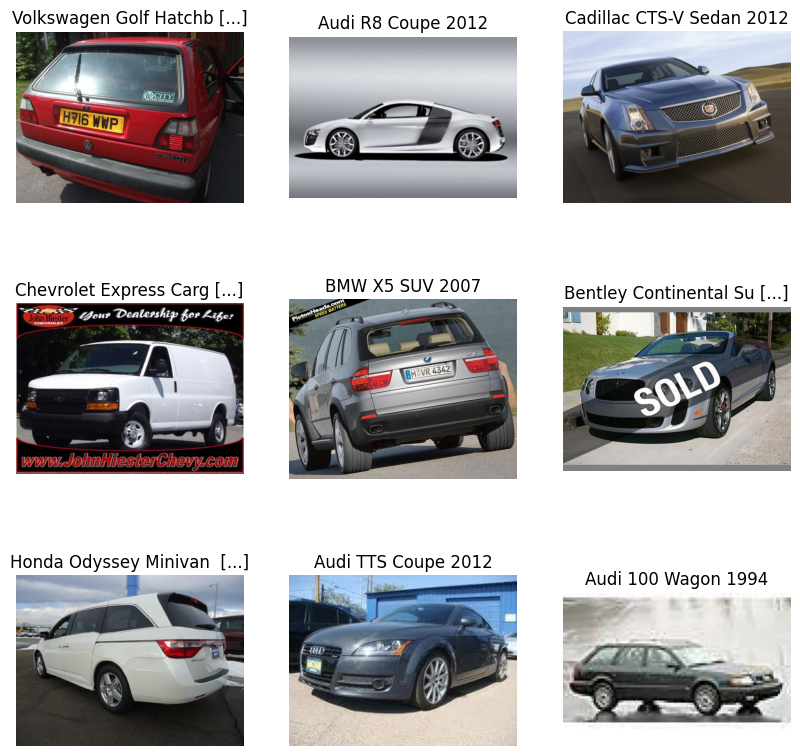

In [9]:
# Visualizing Random Samples from Training Data
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(TRAIN_PATH), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(TRAIN_PATH, class_name)))
    image_path = os.path.join(TRAIN_PATH, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight inside datasets

We'll now count the number of cars in each class within the training dataset and visualize the counts using a bar plot. Additionally, we'll show the mean number of samples and plot it as a horizontal line for reference.

In [10]:
car_count_dict = {}

for class_folder in os.listdir(TRAIN_PATH):
    count = len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
    car_count_dict[class_folder] = count

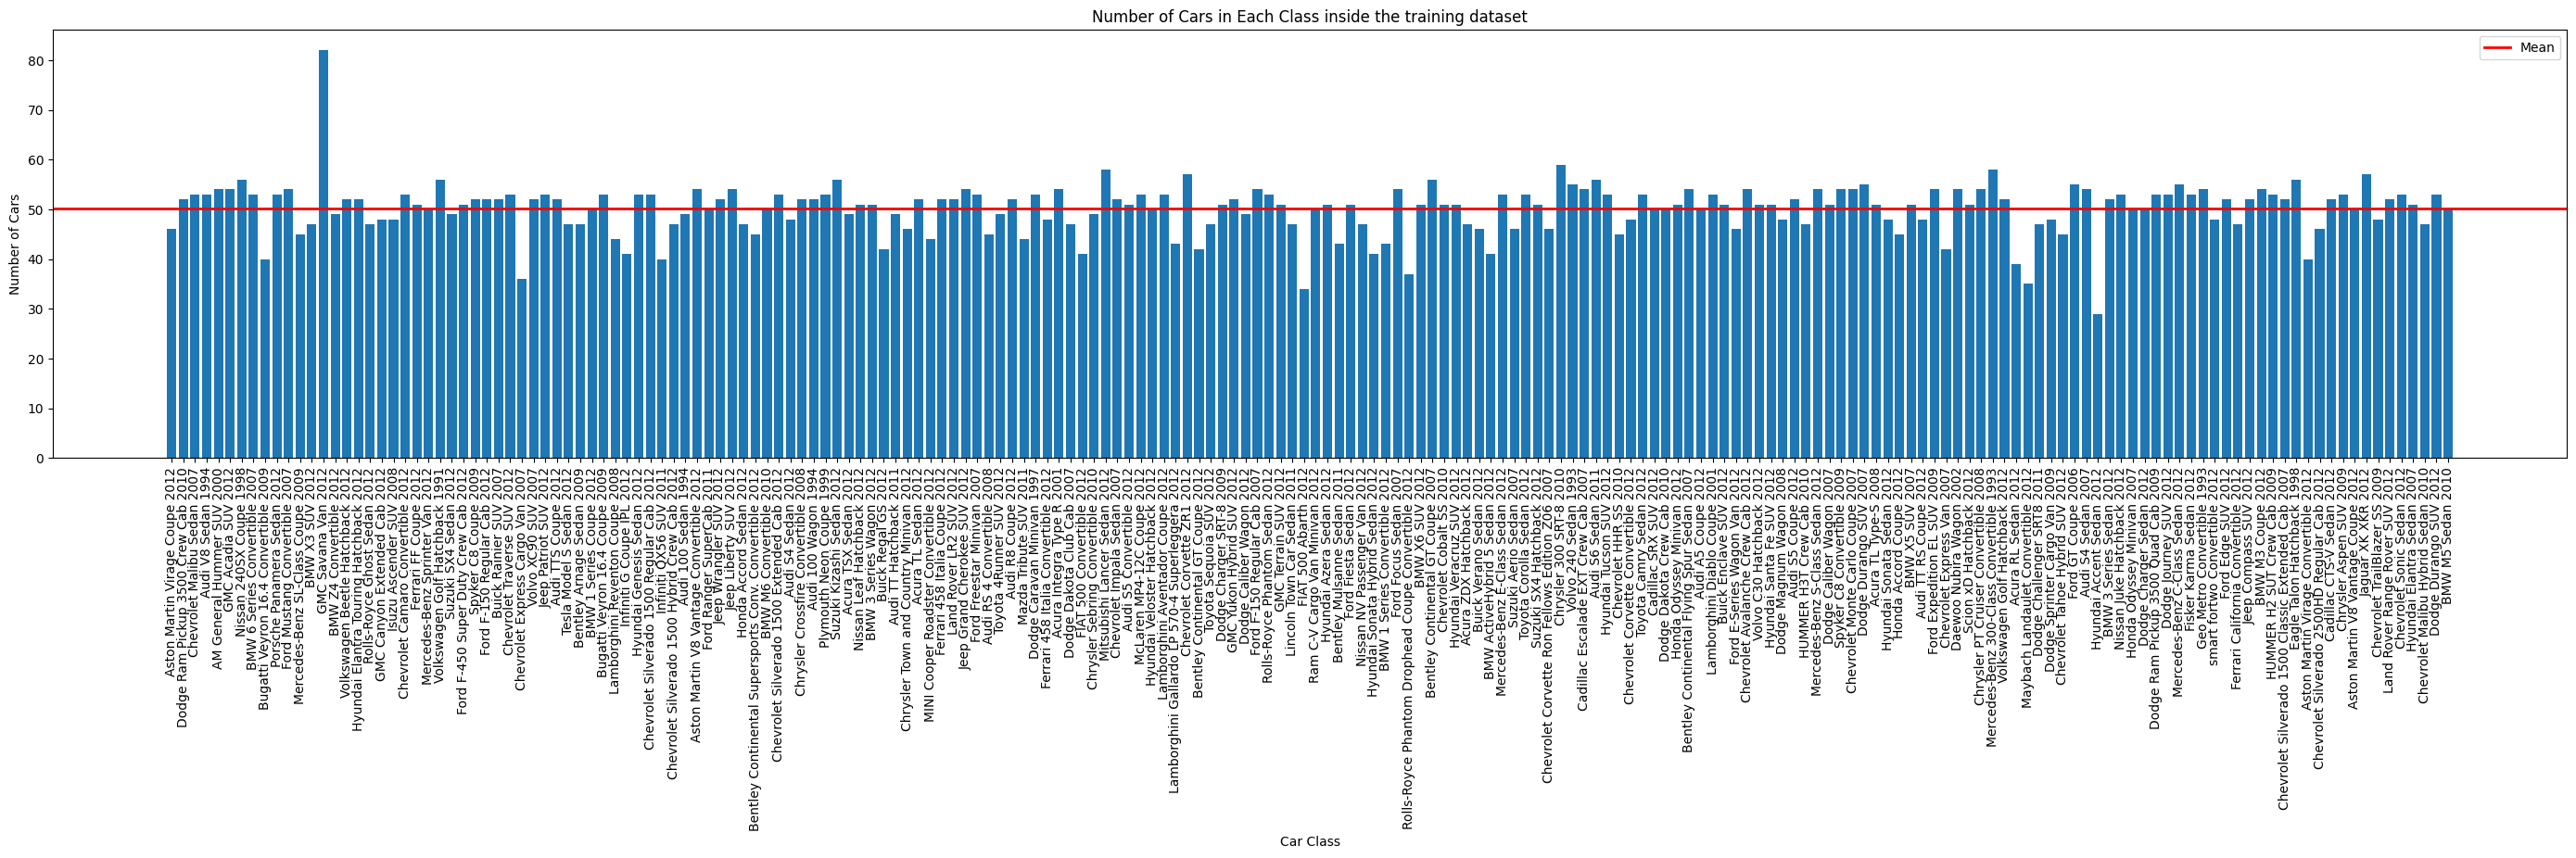

In [11]:
# Visualizing the car counts for each class
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the training dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

**Discussion:** As we can see, the dataset is a bit unbalanced. As a result we may consider to add class weights inside the loss of our future model.

**The goal is to penalyze overrepresented and promote underrepresented classes.**

### Retrieve the consistency of the Test Dataset

Let's take a peek at the test dataset now! We'll count the number of cars in each class within the test dataset and visualize the counts using a bar plot. Ever wondered how many cars of each type are in the test set? Let's find out!

In [12]:
car_count_dict = {}

for class_folder in os.listdir(TEST_PATH):
    count = len(os.listdir(os.path.join(TEST_PATH, class_folder)))
    car_count_dict[class_folder] = count

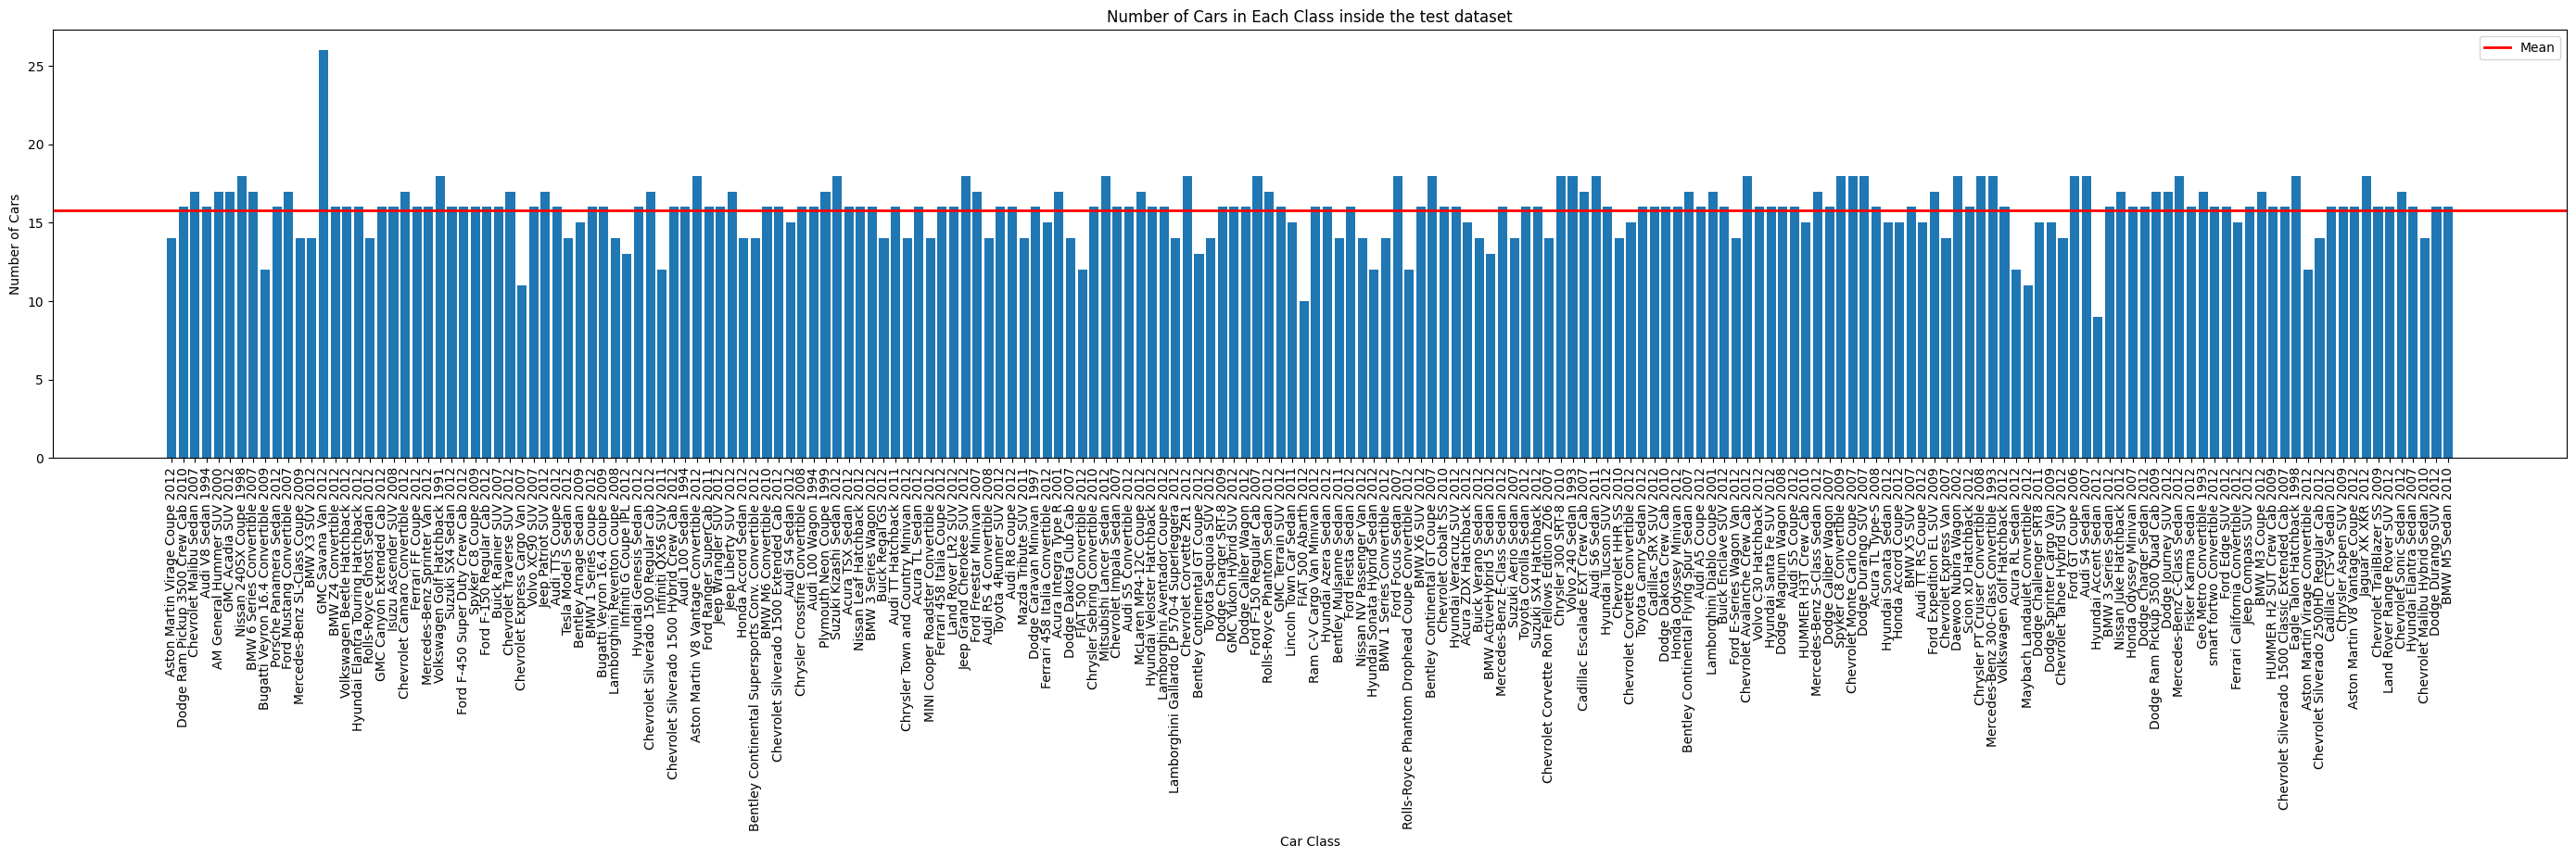

In [13]:
# Visualizing the car counts for each class in the test dataset
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the test dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

**Discussion:** The distribution closely mirrors that of the training dataset. We selected 20% of the total dataset to ensure a minimum average of 16 images per class.

### Preparing the Data for Model Training

It's time to whip our data into shape for training! But first, let's see how many CPU cores we have at our disposal to speed up the process.

In [14]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 4


In [15]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

**Data augmentation**

With that out of the way, let's dive into transforming our dataset. We've imported some transformation tricks straight from ImageNet to ensure our data is in top-notch condition.

We'll resize our images to 224x224 pixels (in order to have a good adaptation for the ResNet18 input layer), apply some random flips and rotations to keep images unique, and sprinkle in some color jitter for good measure.

Finally, we'll convert everything into tensors and give them a good normalization using mean and standard deviation values borrowed from the mighty ImageNet. Our data will be primed and ready for our model's consumption!

In [16]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

val_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

### Loading Data for Model Training

It's time to load up our data and get it ready for the training! We're about to create some loaders that will help us feed our data into the model efficiently. But first, let's set the stage with some batch sizes and multiprocessing magic.


In [17]:
BATCH_SIZE = 32

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

val_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = val_train_augmentation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_train_augmentation)

# Create a dictionary to associate image indices with image path
image_index_to_path = defaultdict(str)
with tqdm(test_dataset) as t_ds:
    for i, (image, _) in tqdm(enumerate(t_ds)):
        image_path = test_dataset.imgs[i][0]
        image_index_to_path[i] = image_path

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

  0%|          | 9/3093 [00:00<00:34, 88.70it/s]
10it [00:00, 98.10it/s]
  7%|▋         | 227/3093 [00:01<00:19, 145.45it/s]
228it [00:01, 145.03it/s]
100%|██████████| 3093/3093 [00:23<00:00, 132.14it/s]
3093it [00:23, 132.15it/s]


### Introducing the ResNet-18 Model!

This model comes straight from torchvision, pre-trained on ImageNet.

In [18]:
model = torchvision.models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s] 


# Exploring Model Parameters

Let's take a peek under the hood and explore the parameters of our ResNet-18 model. These parameters hold the key to the inner workings of the model, including weights and biases of each layer.

In [19]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

Let's compute the class weights based on the distribution of samples in each class.

In [20]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(TRAIN_PATH):
    label_to_int[class_name] = counter
    counter += 1

# Get an histogram of the classes weight
sample_to_int = []
for class_folder in os.listdir(TRAIN_PATH):
    for _ in os.listdir(os.path.join(TRAIN_PATH, class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

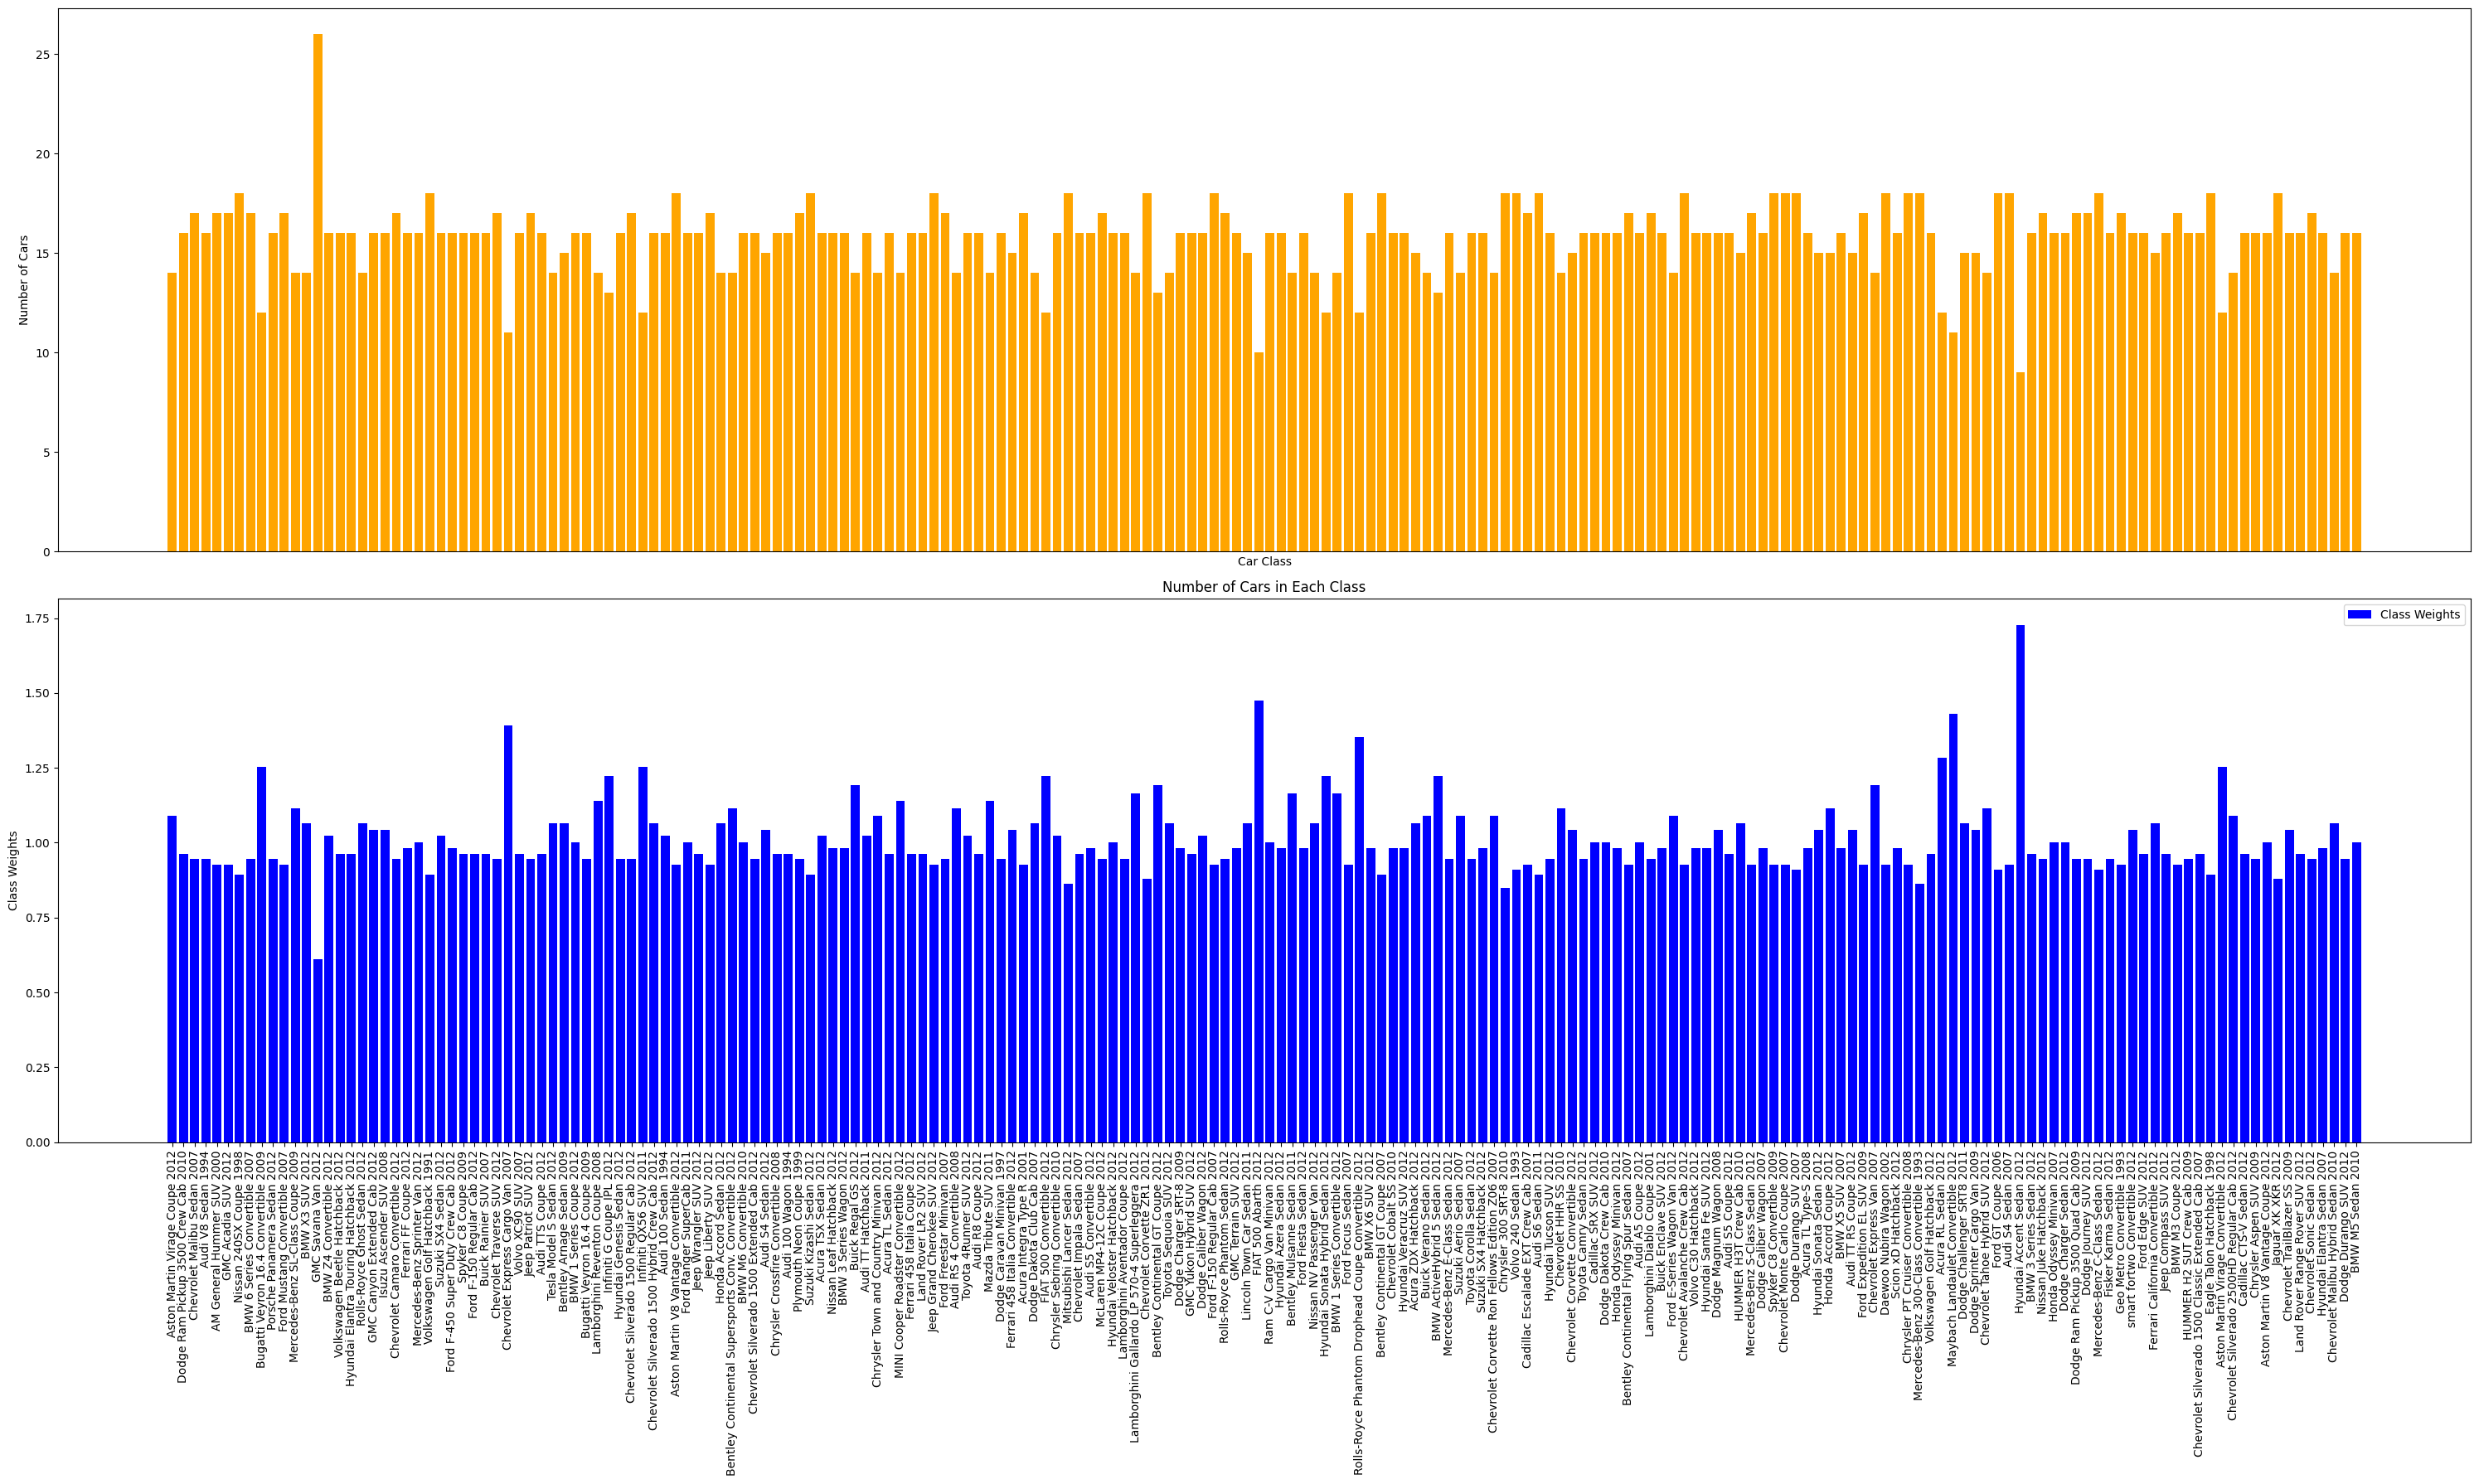

In [21]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Discussion:** Here is the penalty we discussed some cells ago. Here we can see the weight distribution corresponding the de samples distribution inside the available classes.

### Setting the Hyper-Parameters and Preparing Model for Training

Let's get our model ready for training! First up, we'll move our model to the specified device (CPU or GPU). Then, we'll define our loss function and optimizer to optimize our model's performance.

In [22]:
model = model.to(device)

# Defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-5) # weight_decay == L2 (riddge)

In [23]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=3, min_lr=0.00001, verbose=True)

With our model on the right device and loss function and optimizer in place, we're all set to embark on our training journey. Let's unleash the power of machine learning and train our model to recognize cars!

# Evaluating and Training the Model

Now it's time to put our model to the test and train it! We'll define two key functions:

1. **eval_model**: This function evaluates the model's performance on the validation dataset, calculating both accuracy and loss.

2. **train_model**: Here comes the main event! This function trains our model using the training dataset, evaluating its performance on the validation dataset after each epoch. It also dynamically adjusts the learning rate based on the validation loss.

Let's dive into the code and kickstart the training process:

In [24]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model: nn.Module, val_loader: torch.utils.data.DataLoader,
               device: torch.device) -> Tuple[float, float]:
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / (BATCH_SIZE * len(test_loader))
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [25]:
def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler.ReduceLROnPlateau,
                device: torch.device, n_epochs: int = 5) -> Dict[str, List[float]]:
    
    history: Dict[str, List[float]] = {
        "losses": [],
        "accuracies": [],
        "test_accuracies": [],
        "test_losses": [],
        "lr": []
    }

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as training_epoch:
            for i, data in enumerate(training_epoch):
                inputs, labels = data

                # Transfer to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                # Optimize the weights
                optimizer.step()
                
                # Calculate the loss and The accuracy
                running_loss += loss.item()
                running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_acc = running_correct / (BATCH_SIZE * len(train_loader))
        epoch_loss = running_loss / len(train_loader)

        history['losses'].append(epoch_loss)
        history['accuracies'].append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, val_loader, device)
        history['test_accuracies'].append(test_acc)
        history['test_losses'].append(test_loss)
        history['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])

        # Print the data
        print("Epoch %s: duration: %d s, acc: %.4f, loss: %.4f, val_acc: %.4f, val_loss: %.4f, lr: %.6f"
            % (epoch + 1, time.time() - since, epoch_acc, epoch_loss, test_acc, test_loss, history['lr'][-1])
        )
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
        
    print('Finished Training')
    return history

In [26]:
NEPOCHS = 30

# Train the model
history = train_model(
    model,
    train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Epoch 1: 100%|██████████| 307/307 [00:57<00:00,  5.35batch/s]


Epoch 1: duration: 69 s, acc: 0.0128, loss: 5.2514, val_acc: 0.0190, val_loss: 5.7904, lr: 0.001000


Epoch 2: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 2: duration: 68 s, acc: 0.0664, loss: 4.3385, val_acc: 0.1021, val_loss: 3.9637, lr: 0.001000


Epoch 3: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 3: duration: 67 s, acc: 0.1553, loss: 3.4967, val_acc: 0.1762, val_loss: 3.4483, lr: 0.001000


Epoch 4: 100%|██████████| 307/307 [00:56<00:00,  5.44batch/s]


Epoch 4: duration: 67 s, acc: 0.2768, loss: 2.8528, val_acc: 0.3235, val_loss: 2.7784, lr: 0.001000


Epoch 5: 100%|██████████| 307/307 [00:56<00:00,  5.45batch/s]


Epoch 5: duration: 67 s, acc: 0.4087, loss: 2.2999, val_acc: 0.4285, val_loss: 2.3136, lr: 0.001000


Epoch 6: 100%|██████████| 307/307 [00:56<00:00,  5.42batch/s]


Epoch 6: duration: 67 s, acc: 0.5202, loss: 1.8716, val_acc: 0.5287, val_loss: 1.8644, lr: 0.001000


Epoch 7: 100%|██████████| 307/307 [00:56<00:00,  5.41batch/s]


Epoch 7: duration: 67 s, acc: 0.6041, loss: 1.5765, val_acc: 0.5255, val_loss: 1.9161, lr: 0.001000


Epoch 8: 100%|██████████| 307/307 [00:57<00:00,  5.34batch/s]


Epoch 8: duration: 68 s, acc: 0.6642, loss: 1.3531, val_acc: 0.6269, val_loss: 1.5328, lr: 0.001000


Epoch 9: 100%|██████████| 307/307 [00:56<00:00,  5.44batch/s]


Epoch 9: duration: 67 s, acc: 0.7149, loss: 1.2032, val_acc: 0.6340, val_loss: 1.5383, lr: 0.001000


Epoch 10: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 10: duration: 68 s, acc: 0.7318, loss: 1.1268, val_acc: 0.6324, val_loss: 1.5227, lr: 0.001000


Epoch 11: 100%|██████████| 307/307 [00:59<00:00,  5.19batch/s]


Epoch 11: duration: 69 s, acc: 0.7750, loss: 0.9912, val_acc: 0.6572, val_loss: 1.4476, lr: 0.001000


Epoch 12: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 12: duration: 67 s, acc: 0.8067, loss: 0.9119, val_acc: 0.6240, val_loss: 1.6215, lr: 0.001000


Epoch 13: 100%|██████████| 307/307 [00:58<00:00,  5.23batch/s]


Epoch 13: duration: 70 s, acc: 0.8185, loss: 0.8552, val_acc: 0.6640, val_loss: 1.4672, lr: 0.001000


Epoch 14: 100%|██████████| 307/307 [00:56<00:00,  5.39batch/s]


Epoch 14: duration: 67 s, acc: 0.8346, loss: 0.8030, val_acc: 0.6688, val_loss: 1.4231, lr: 0.001000


Epoch 15: 100%|██████████| 307/307 [00:56<00:00,  5.43batch/s]


Epoch 15: duration: 67 s, acc: 0.8528, loss: 0.7488, val_acc: 0.6888, val_loss: 1.3651, lr: 0.001000


Epoch 16: 100%|██████████| 307/307 [00:58<00:00,  5.22batch/s]


Epoch 16: duration: 70 s, acc: 0.8643, loss: 0.7227, val_acc: 0.6801, val_loss: 1.4473, lr: 0.001000


Epoch 17: 100%|██████████| 307/307 [00:56<00:00,  5.46batch/s]


Epoch 17: duration: 67 s, acc: 0.8816, loss: 0.6753, val_acc: 0.7049, val_loss: 1.3443, lr: 0.001000


Epoch 18: 100%|██████████| 307/307 [00:56<00:00,  5.42batch/s]


Epoch 18: duration: 67 s, acc: 0.8832, loss: 0.6634, val_acc: 0.7120, val_loss: 1.3004, lr: 0.001000


Epoch 19: 100%|██████████| 307/307 [00:56<00:00,  5.46batch/s]


Epoch 19: duration: 67 s, acc: 0.8974, loss: 0.6292, val_acc: 0.7033, val_loss: 1.3150, lr: 0.001000


Epoch 20: 100%|██████████| 307/307 [00:56<00:00,  5.43batch/s]


Epoch 20: duration: 67 s, acc: 0.8998, loss: 0.6110, val_acc: 0.7387, val_loss: 1.2409, lr: 0.001000


Epoch 21: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 21: duration: 67 s, acc: 0.9105, loss: 0.5838, val_acc: 0.7142, val_loss: 1.3264, lr: 0.001000


Epoch 22: 100%|██████████| 307/307 [00:56<00:00,  5.43batch/s]


Epoch 22: duration: 67 s, acc: 0.9100, loss: 0.5788, val_acc: 0.7320, val_loss: 1.2358, lr: 0.001000


Epoch 23: 100%|██████████| 307/307 [00:57<00:00,  5.38batch/s]


Epoch 23: duration: 67 s, acc: 0.9179, loss: 0.5617, val_acc: 0.7007, val_loss: 1.3293, lr: 0.001000


Epoch 24: 100%|██████████| 307/307 [00:56<00:00,  5.40batch/s]


Epoch 24: duration: 67 s, acc: 0.9132, loss: 0.5671, val_acc: 0.7152, val_loss: 1.3008, lr: 0.001000


Epoch 25: 100%|██████████| 307/307 [00:56<00:00,  5.41batch/s]


Epoch 25: duration: 68 s, acc: 0.9154, loss: 0.5665, val_acc: 0.6939, val_loss: 1.3879, lr: 0.001000


Epoch 26: 100%|██████████| 307/307 [00:56<00:00,  5.44batch/s]


Epoch 26: duration: 67 s, acc: 0.9248, loss: 0.5422, val_acc: 0.7313, val_loss: 1.2424, lr: 0.001000
Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.


Epoch 27: 100%|██████████| 307/307 [00:57<00:00,  5.39batch/s]


Epoch 27: duration: 67 s, acc: 0.9686, loss: 0.4096, val_acc: 0.8144, val_loss: 0.9366, lr: 0.000100


Epoch 28: 100%|██████████| 307/307 [00:56<00:00,  5.43batch/s]


Epoch 28: duration: 67 s, acc: 0.9850, loss: 0.3599, val_acc: 0.8231, val_loss: 0.9075, lr: 0.000100


Epoch 29: 100%|██████████| 307/307 [00:56<00:00,  5.42batch/s]


Epoch 29: duration: 67 s, acc: 0.9883, loss: 0.3437, val_acc: 0.8322, val_loss: 0.8913, lr: 0.000100


Epoch 30: 100%|██████████| 307/307 [00:56<00:00,  5.43batch/s]


Epoch 30: duration: 67 s, acc: 0.9897, loss: 0.3347, val_acc: 0.8296, val_loss: 0.8795, lr: 0.000100
Finished Training


### Load a model

You can bring your trained model back to life for debugging purposes. Uncomment the code to use this part.

In [27]:
# Load model architecture
#model = torch.load('save/model.pth')

# Create a new instance of the same model architecture
# For example, if you're using a custom model class:
# model = MyModelClass()

# Load the trained parameters (state_dict) into the model
#model.load_state_dict(torch.load('save/model_state_dict.pth'))

### Saving Model's Architecture and State Dictionary

To preserve our model's hard-earned knowledge, we'll save both its architecture and state dictionary:

In [28]:
create_dir('save')
# Save model's Architecture
torch.save(model, 'model.pth')

# Save model's state_dict
torch.save(model.state_dict(), 'model_state_dict.pth')

### Visualizing Training and Validation Performance

Let's take a closer look at how our model performed during training and validation. We'll plot two key metrics over epochs:

1. **Training Loss vs. Validation Loss**: This plot helps us monitor the model's convergence and identify overfitting or underfitting.
2. **Training Accuracy vs. Validation Accuracy**: Here, we can see how well our model generalizes to unseen data compared to the training set.

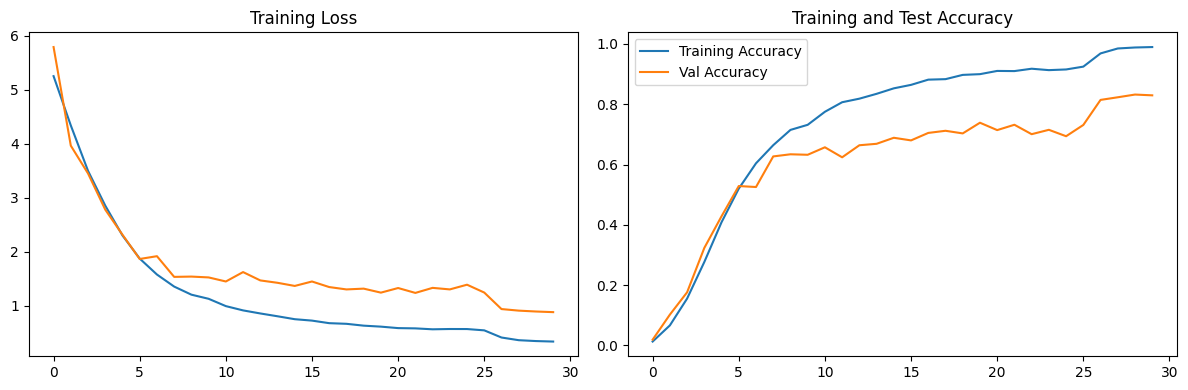

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Analyzing Learning Rate Evolution

Let's dive into the evolution of our model's learning rate over epochs. This plot provides crucial insights into how the learning rate changes during training, which can impact the model's convergence and performance.

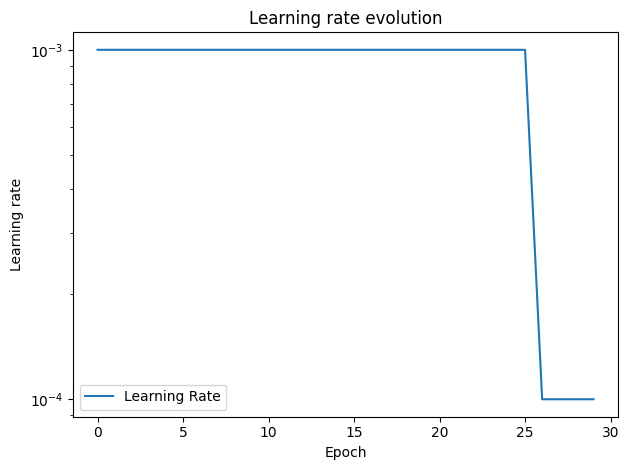

In [30]:
plt.plot(history['lr'])
plt.title("Learning rate evolution")
plt.legend(["Learning Rate"])

plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.yscale('log')
plt.tight_layout()
plt.show()

## Evaluating Model Performance on Test Dataset

It's time to put our trained model to the test and see how well it performs on unseen data! Here's what we're doing:

1. **Evaluation**: We set our model to evaluation mode and iterate over the test dataset to make predictions.

2. **Confusion Matrix**: We compute the confusion matrix to understand how well our model is classifying different classes.

3. **Accuracy**: We calculate the final accuracy achieved on the test dataset and print it out for analysis.

Let's dive into the code and see how our model fares in the real world!

In [31]:
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

Final accuracy on the test dataset
0.8325250565793728


### Visualizing Confusion Matrix

Let's visualize the confusion matrix to understand how well our model is performing across different classes. Here's what we're doing:

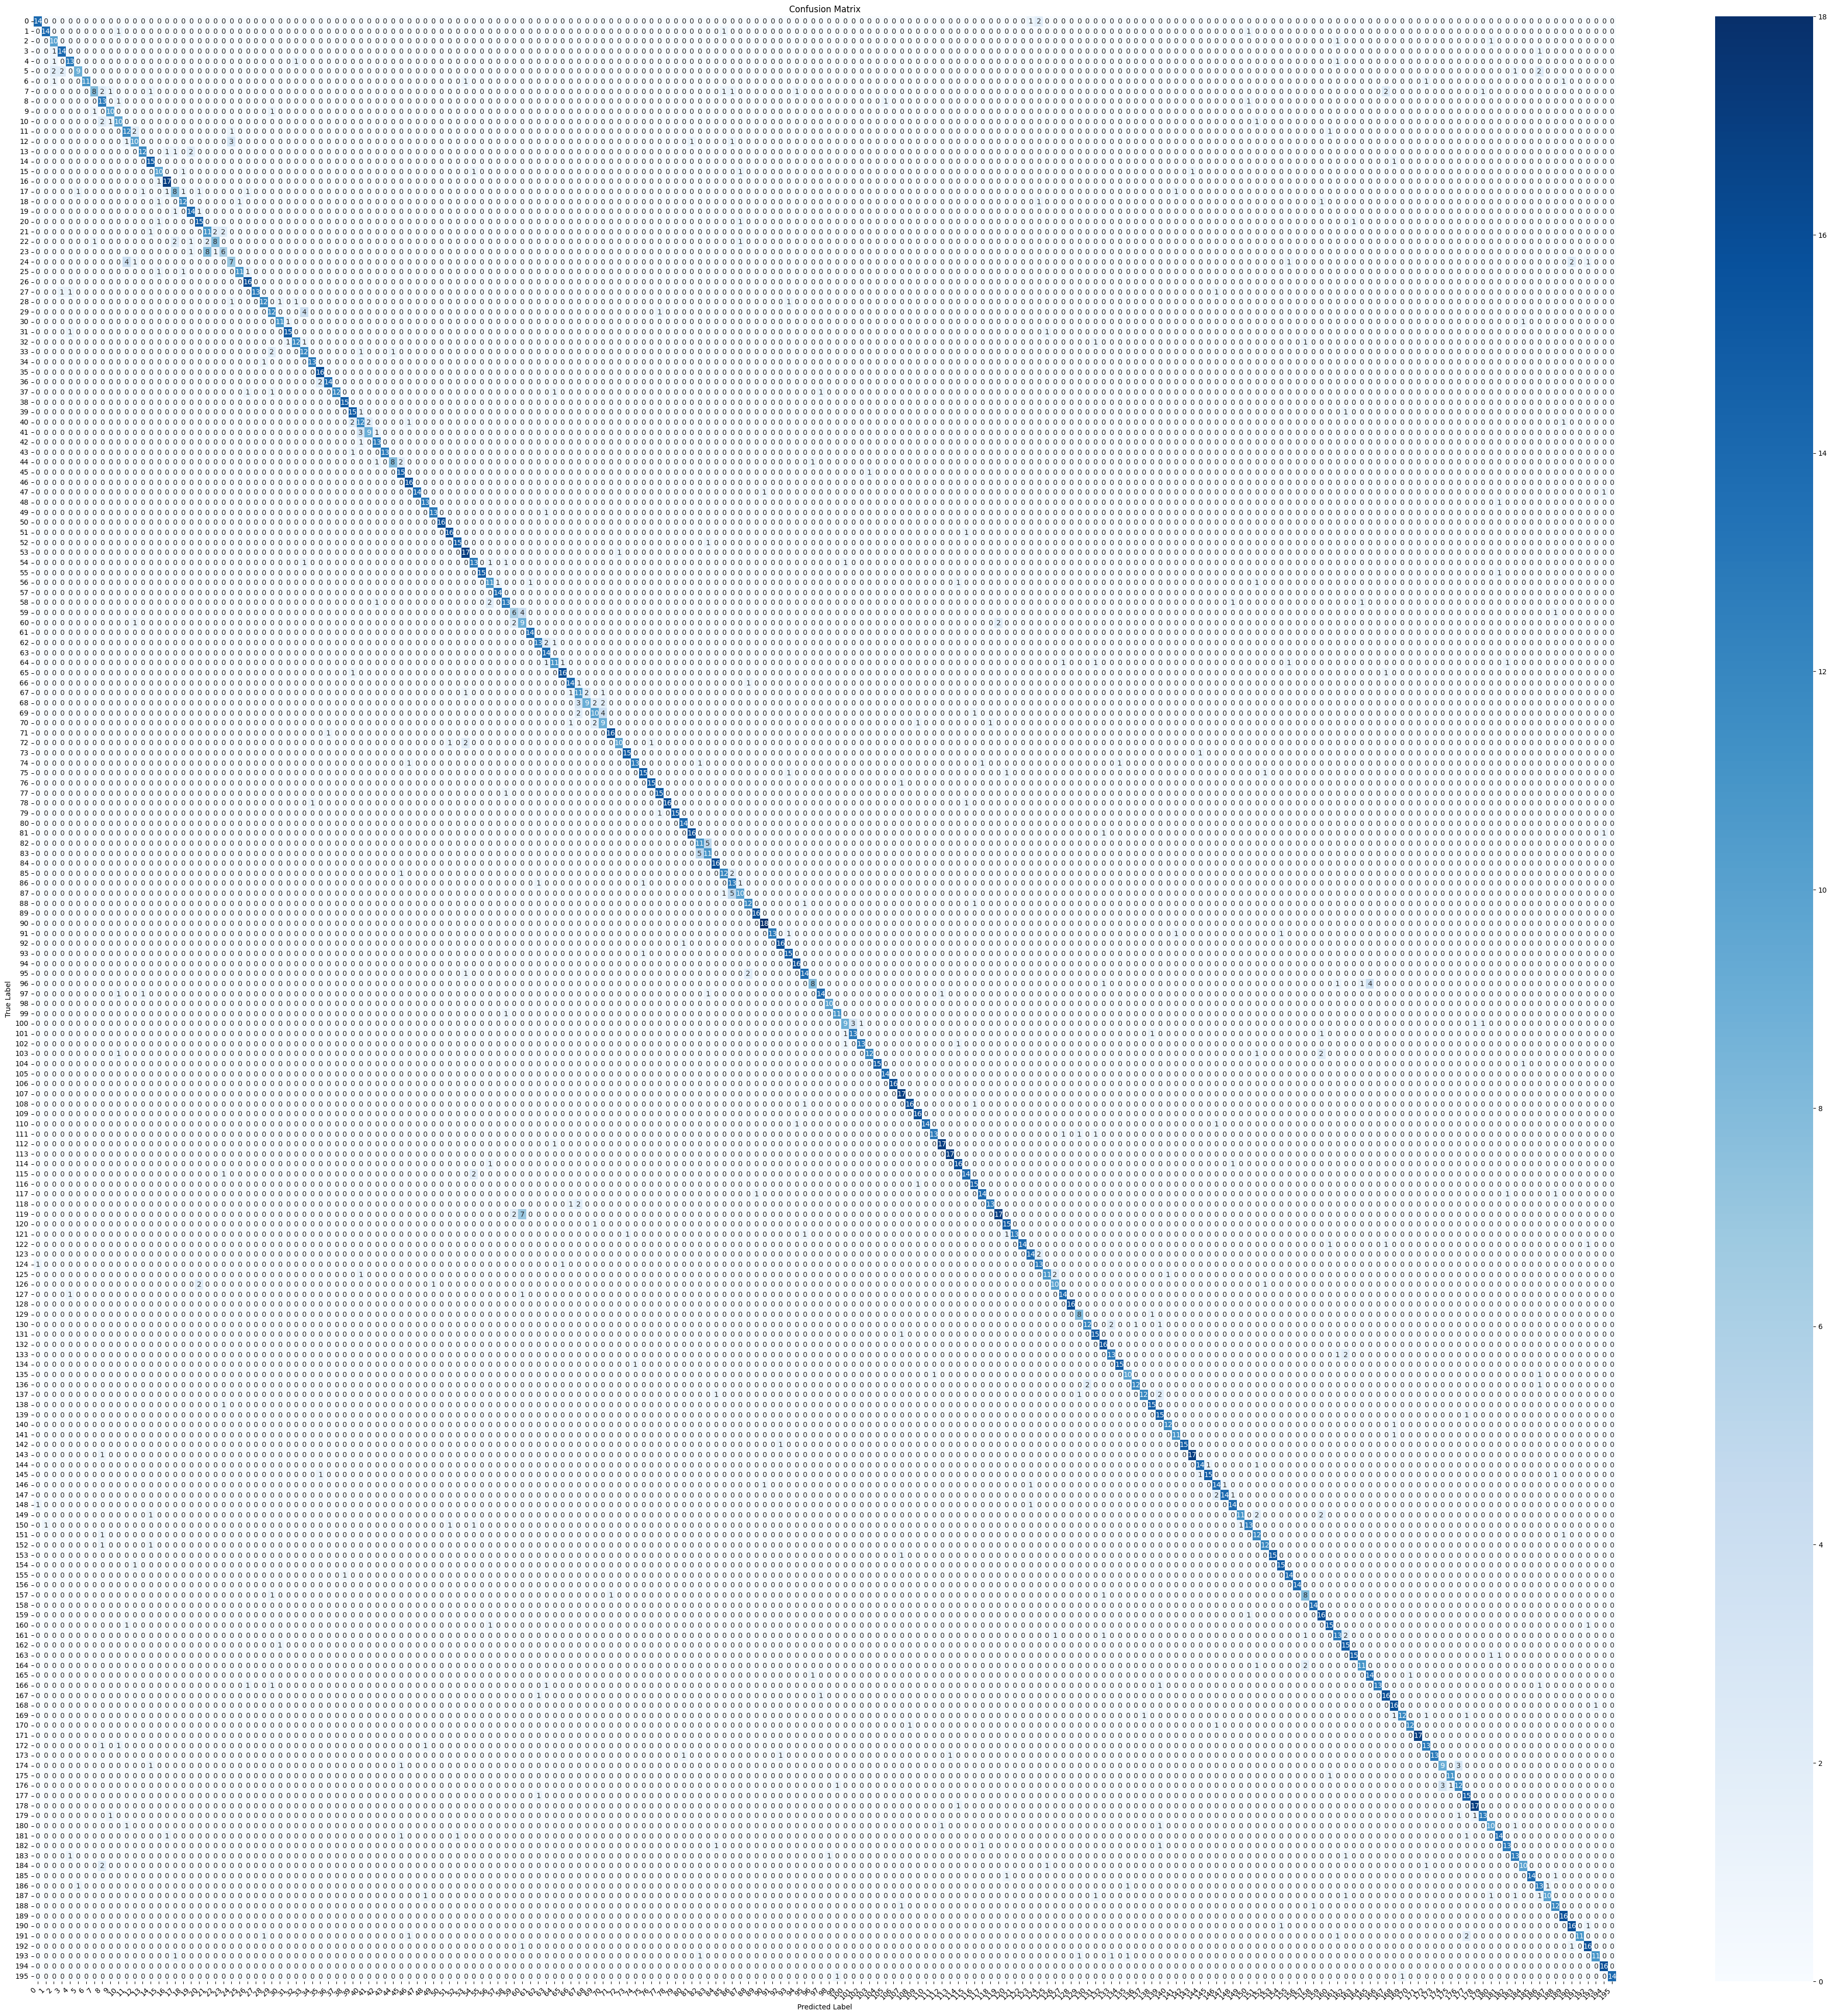

In [32]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

### Classification Report

Let's generate and analyze the classification report for our model's predictions on the test dataset. Here's what we're doing:

In [33]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.93      0.82      0.87        17
           2       0.67      0.83      0.74        12
           3       0.82      0.88      0.85        16
           4       0.76      0.81      0.79        16
           5       0.82      0.56      0.67        16
           6       1.00      0.73      0.85        15
           7       0.80      0.44      0.57        18
           8       0.57      0.81      0.67        16
           9       0.77      0.83      0.80        12
          10       0.67      0.71      0.69        14
          11       0.63      0.75      0.69        16
          12       0.67      0.62      0.65        16
          13       0.86      0.75      0.80        16
          14       0.75      0.94      0.83        16
          15       0.71      0.71      0.71        14
          16       0.85      0.94      0.89        18
          17       0.62    

# Analyzing Incorrect Predictions

Let's take a closer look at the samples where our model made incorrect predictions. Here's what we're doing:

1. **Identification**: We identify the incorrect predictions and their corresponding probabilities.

2. **Sorting**: The incorrect predictions are sorted based on prediction confidence (probability), allowing us to focus on the most uncertain predictions.

3. **Displaying Samples Metrics**: We display the details of the 9 samples with the worst predictions, including their true labels, predicted labels, and probabilities.

Let's dive into the code and analyze these examples to understand where our model struggles and how we can improve its performance.


In [34]:
import numpy as np

# Find incorrect predictions and their corresponding probabilities
incorrect_predictions = []
for i, (true_label, predicted_label, prob) in enumerate(zip(true_labels, predicted_labels, predicted_probs)):
    if true_label != predicted_label:
        incorrect_predictions.append((i, true_label, predicted_label, prob))

# Sort the incorrect predictions based on prediction confidence (probability)
incorrect_predictions.sort(key=lambda x: x[3])

# Get the 9 samples with the worst loss predictions
print("Samples with the worst predictions:")
input_path = []

for i in range(9):
    index, true_label, predicted_label, prob = incorrect_predictions[i]
    input_path.append(image_index_to_path[index])
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {prob}")

Samples with the worst predictions:
True Label: 161, Predicted Label: 157, Probability: -2.6423537731170654
True Label: 180, Predicted Label: 139, Probability: -1.918869972229004
True Label: 74, Predicted Label: 117, Probability: -1.7101606130599976
True Label: 193, Predicted Label: 133, Probability: -1.6334503889083862
True Label: 150, Predicted Label: 51, Probability: -1.6284925937652588
True Label: 58, Predicted Label: 148, Probability: -1.5164496898651123
True Label: 138, Predicted Label: 23, Probability: -1.4829188585281372
True Label: 131, Predicted Label: 107, Probability: -1.470672845840454
True Label: 96, Predicted Label: 164, Probability: -1.450263261795044


### Visualizing Activation Maps for Incorrect Predictions

Let's visualize the activation maps for the images where our model made incorrect predictions. Here's what we're doing:

1. **Activation Map Extraction**: We use SmoothGradCAM++ to extract the activation maps for each image in our list of incorrect predictions.

2. **Overlay Masks**: We visualize these activation maps alongside the corresponding images to understand which regions of the images are influencing our model's decisions.

Let's dive into the code and explore these activation maps to gain insights into our model's decision-making process.

In [35]:
activation_map = []
images_map = []

model.eval()
with SmoothGradCAMpp(model) as cam_extractor:
    for error_path in input_path:
        img = read_image(error_path)
        input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        input_tensor = input_tensor.to(device)
        out = model(input_tensor.unsqueeze(0))
        
        # Retrieve the CAM by passing the class index and the model output
        images_map.append(img)
        activation_map.append(cam_extractor(out.squeeze(0).argmax().item(), out))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


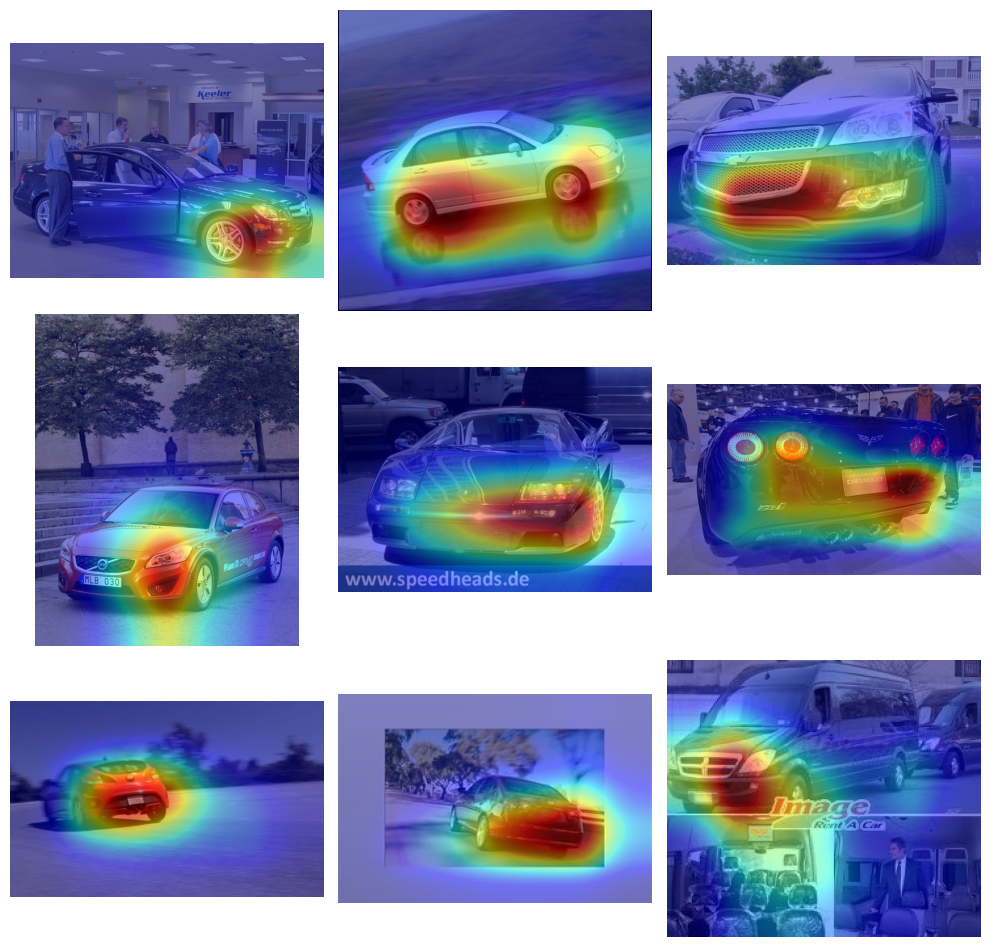

In [36]:
# Display each image on a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
get_attention_images = []
for i, (img, act_map) in enumerate(zip(images_map, activation_map)):
    result = overlay_mask(to_pil_image(img), to_pil_image(act_map[0].squeeze(0), mode='F'), alpha=0.5)
    exploit_mask = overlay_mask(to_pil_image(img), to_pil_image(act_map[0].squeeze(0), mode='F'), alpha=0.0)
    
    get_attention_images.append(exploit_mask)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(result)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Génération de données d'entraînement SmoothGradCAM++

**Fonction smooth_grad_training_data**
Cette fonction génère des données d'entraînement ainsi que des cartes d'activation SmoothGradCAM++. Elle prend en paramètre `class_name` indiquant la classe pour laquelle les données d'entraînement sont générées.
1. Elle itère sur les images dans le répertoire de classe spécifié.
2. Prétraite chaque image.
3. Passe chaque image prétraitée à travers un modèle.
4. Extrait la CAM (Carte d'Activation de Classe) en utilisant SmoothGradCAM++.
5. Ajoute le tenseur CAM à une liste.
6. Renvoie une liste d'images PIL (images originales) et une liste de cartes d'activation en tant que tenseurs.

**Fonction pil_to_tensor**
Convertit une image PIL en un tenseur PyTorch.

**Fonction get_mask_img**
Cette fonction génère des cartes de masque sur les images.
1. Elle appelle `smooth_grad_training_data` pour obtenir des cartes d'activation et des images originales.
2. Itère sur chaque paire d'image originale et de carte d'activation.
3. Convertit la carte d'activation en une image PIL.
4. La superpose sur l'image originale.
5. Convertit la superposition en un tenseur et l'ajoute à une liste.
6. Renvoie une liste d'images PIL (images originales) et une liste de cartes de masque en tant que tenseurs.

In [37]:
from torchvision.transforms import functional as F

def smooth_grad_training_data(class_name: str) -> tuple:
    """
    Generates training data with SmoothGradCAM++ activation maps.

    Parameters:
    - class_name (str): The name of the class for which training data is generated.

    Returns:
    - List: A list containing activation maps as tensors.
    """
    activation_map_tensor = []
    images_map_pil = []

    with SmoothGradCAMpp(model) as cam_extractor:
        for sample_name in os.listdir(os.path.join(TRAIN_PATH, class_name)):
            sample_path = os.path.join(TRAIN_PATH, class_name, sample_name)
            img = read_image(sample_path)
            
            if img.size()[0] == 1:  # Single channel image
                print('Skipping Grayscale image ->', sample_path)
                continue
            input_tensor = normalize(
                resize(img, (224, 224)) / 255.,
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            )
            
            input_tensor = input_tensor.to(device)
            out = model(input_tensor.unsqueeze(0))

            # Retrieve the CAM 
            images_map_pil.append(img)
            cam = cam_extractor(out.squeeze(0).argmax().item(), out)

            # Append the mask to a list of masks        
            activation_map_tensor.append(cam)
    
    return images_map_pil, activation_map_tensor

def pil_to_tensor(image_pil):
    """Convert PIL Image to a PyTorch tensor."""
    transform = transforms.ToTensor()
    return transform(image_pil)

def get_mask_img(class_name: str) -> tuple:
    """
    Generates mask maps over images.

    Parameters:
    - class_name (str): The name of the class for which training data is generated.

    Returns:
    - List: A list containing mask maps as tensors.
    """
    mask_tensor = []
    images_map_pil, activation_map_tensor = smooth_grad_training_data(class_name)
    for i, (img, act_map) in enumerate(zip(images_map_pil, activation_map_tensor)):
        mask = to_pil_image(act_map[0].squeeze(0), mode='F')

        # Append the mask to the list of masks
        mask_tensor.append(pil_to_tensor(overlay_mask(to_pil_image(img), mask, alpha=0.01)))
    
    return images_map_pil, mask_tensor

### Application de flou variable sur l'application de masque

Ce code définit une fonction pour appliquer un flou variable sur une image en fonction d'un masque.

**Fonction `apply_variable_blur_on_mask`**
Cette fonction prend en entrée un tenseur d'image et un tenseur de masque et applique un flou variable à l'image en fonction du masque.
1. Convertit les tenseurs d'image et de masque en images PIL.
2. Divise le masque en canaux séparés (R, V, B).
3. Détermine le masque alpha en comparant le canal rouge aux canaux vert et bleu.
4. Applique un flou gaussien à l'image en utilisant le rayon de flou maximum spécifié.
5. Combine l'image floue avec l'image originale en fonction du masque alpha pour créer l'image finale.
6. Convertit l'image finale en un tenseur et la retourne.

Le flou variable est appliqué sélectivement aux pixels de l'image en fonction des conditions spécifiées dans le masque alpha, ce qui permet d'obtenir des effets de flou personnalisables.

In [38]:
from PIL import Image, ImageFilter, ImageChops
from torchvision.transforms import ToPILImage, ToTensor

def apply_variable_blur_on_mask(image_tensor, mask_tensor, max_blur_radius=5):
    # Convert tensors to PIL Images
    to_pil = ToPILImage()
    image_pil = to_pil(image_tensor)
    mask_pil = to_pil(mask_tensor)

    # Split mask into separate channels
    r, g, b = mask_pil.split()
    r_tensor = ToTensor()(r)
    g_tensor = ToTensor()(g)
    b_tensor = ToTensor()(b)

    # Only blur pixels respecting the following condition
    alpha_tensor = (r_tensor >= 2 * g_tensor) & (r_tensor >= 2 * b_tensor)

    alpha = ToPILImage(mode='L')(alpha_tensor.float())

    # apply gaussian blur to the image
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(max_blur_radius))

    # Create a new image with the blur
    final_image = Image.new("RGB", image_pil.size)
    final_image.paste(blurred_image, (0, 0), alpha)
    final_image.paste(image_pil, (0, 0), ImageChops.invert(alpha))

    # Convert back to tensor
    to_tensor = ToTensor()
    result_tensor = to_tensor(final_image)

    return result_tensor

## Floutage d'images et sauvegarde

Ce segment de code crée des images floutées basées sur des cartes d'activation et les sauvegarde dans un répertoire.

### Variables
- `FOLDER_NAME`: Le nom du répertoire où les images floutées seront sauvegardées.
- `anciennes_images_d_entrainement`: Liste des classes provenant du répertoire d'images d'entraînement d'origine.

In [39]:
# Create a directory to save the blurred images
FOLDER_NAME = "blur_train"
create_dir(FOLDER_NAME)
old_training_images = os.listdir(TRAIN_PATH)
print(f"number of classes: {len(old_training_images)}")


for class_name in tqdm(old_training_images):
    create_dir(os.path.join(FOLDER_NAME, class_name))
    images_map_pil, mask_tensor = get_mask_img(class_name)
    
    # Apply blur to the images based on activation map and save them
    for i, (original_image_tensor, activation) in enumerate(zip(images_map_pil, mask_tensor)):

        #function applying blur to the original image
        blurred_image_tensor = apply_variable_blur_on_mask(original_image_tensor, activation, 5)
        blurred_image_pil = transforms.ToPILImage()(blurred_image_tensor)

        # Display or save the result
        # blurred_image_pil.show()
        
        blurred_image_pil.save(os.path.join(DATA_PATH, FOLDER_NAME, class_name, f"blurred_{i}.jpg"))

number of classes: 196


  2%|▏         | 3/196 [00:16<16:56,  5.27s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi V8 Sedan 1994/06912.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi V8 Sedan 1994/04848.jpg


  6%|▌         | 11/196 [01:05<20:58,  6.80s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Mercedes-Benz SL-Class Coupe 2009/04288.jpg


 13%|█▎        | 26/196 [02:56<19:34,  6.91s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Spyker C8 Coupe 2009/05502.jpg


 17%|█▋        | 33/196 [03:56<27:45, 10.22s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi TTS Coupe 2012/01085.jpg


 21%|██▏       | 42/196 [04:55<18:02,  7.03s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Infiniti QX56 SUV 2011/05635.jpg


 22%|██▏       | 44/196 [05:03<13:24,  5.29s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/08137.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/07693.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/08144.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/07774.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/05177.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/06947.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Sedan 1994/00266.jpg
Skipping Grayscale image -> /kaggle/worki

 28%|██▊       | 55/196 [06:20<16:14,  6.91s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Wagon 1994/07383.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Wagon 1994/03439.jpg
Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi 100 Wagon 1994/05713.jpg


 45%|████▍     | 88/196 [10:11<13:46,  7.66s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/03469.jpg


 61%|██████    | 119/196 [13:28<10:27,  8.16s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chrysler 300 SRT-8 2010/02408.jpg


 63%|██████▎   | 124/196 [14:08<09:37,  8.02s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chevrolet HHR SS 2010/03048.jpg


 66%|██████▋   | 130/196 [14:48<07:34,  6.88s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/00034.jpg


 73%|███████▎  | 143/196 [16:00<04:34,  5.19s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Spyker C8 Convertible 2009/04577.jpg


 93%|█████████▎| 182/196 [20:28<01:47,  7.68s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Eagle Talon Hatchback 1998/00545.jpg


 94%|█████████▍| 184/196 [20:46<01:38,  8.20s/it]

Skipping Grayscale image -> /kaggle/working/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/03539.jpg


100%|██████████| 196/196 [22:09<00:00,  6.78s/it]


### Display random Images in the BLUR Dataset

['Buick Regal GS 2012', 'BMW X5 SUV 2007', 'FIAT 500 Convertible 2012', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Geo Metro Convertible 1993', 'Volvo XC90 SUV 2007', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Dodge Ram Pickup 3500 Quad Cab 2009']


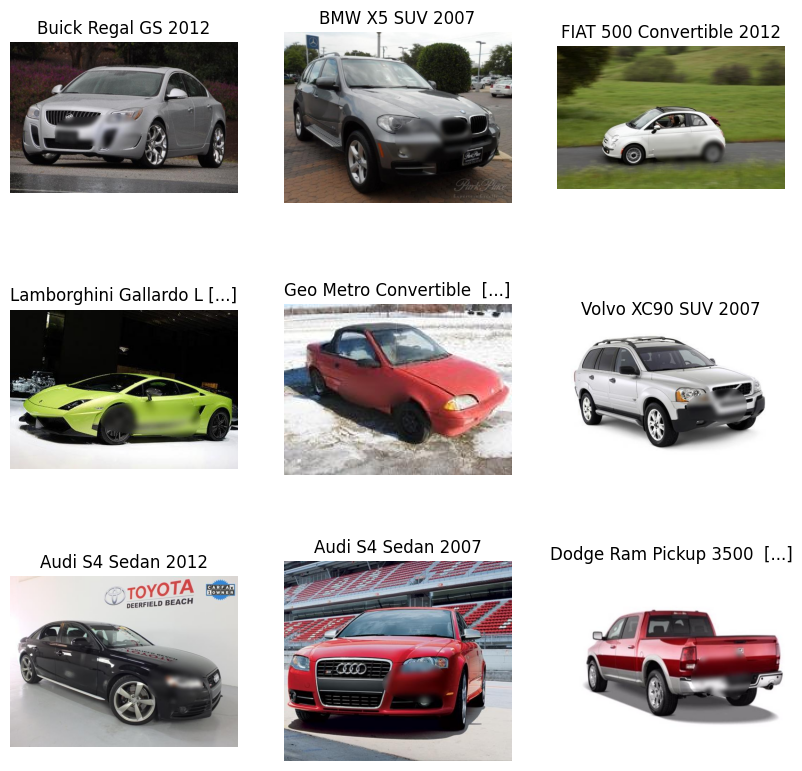

In [40]:
# Visualizing Random Samples from Training Data
plt.figure(figsize=(10, 10))
NEW_TRAIN_DATA = os.path.join(DATA_PATH, FOLDER_NAME)
classes_directory = random.choices(os.listdir(NEW_TRAIN_DATA), k=9)
print(classes_directory)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(NEW_TRAIN_DATA, class_name)))
    image_path = os.path.join(NEW_TRAIN_DATA, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

## Create and Train another model on the BLUR Dataset

In [41]:
new_train_dataset = torchvision.datasets.ImageFolder(root=NEW_TRAIN_DATA, transform = train_augmentation)
new_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

In [44]:
new_model = torchvision.models.resnet18(progress=True, pretrained=True)

num_ftrs = new_model.fc.in_features
no_classes = len(train_dataset.classes)
new_model.fc = nn.Linear(num_ftrs, no_classes)
new_model = new_model.to(device)

# Defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(new_model.parameters(), weight_decay=5e-5)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=3, min_lr=0.00001, verbose=True)

NEPOCHS = 30

# Train the model
history = train_model(
    new_model,
    new_train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Epoch 1: 100%|██████████| 307/307 [00:58<00:00,  5.27batch/s]


Epoch 1: duration: 69 s, acc: 0.0083, loss: 5.3704, val_acc: 0.0116, val_loss: 5.1838, lr: 0.001000


Epoch 2: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 2: duration: 69 s, acc: 0.0140, loss: 5.0854, val_acc: 0.0084, val_loss: 6.0972, lr: 0.001000


Epoch 3: 100%|██████████| 307/307 [00:58<00:00,  5.28batch/s]


Epoch 3: duration: 69 s, acc: 0.0305, loss: 4.6650, val_acc: 0.0280, val_loss: 5.3295, lr: 0.001000


Epoch 4: 100%|██████████| 307/307 [00:58<00:00,  5.24batch/s]


Epoch 4: duration: 69 s, acc: 0.0772, loss: 4.0897, val_acc: 0.0925, val_loss: 3.9778, lr: 0.001000


Epoch 5: 100%|██████████| 307/307 [00:58<00:00,  5.28batch/s]


Epoch 5: duration: 69 s, acc: 0.1439, loss: 3.5152, val_acc: 0.1798, val_loss: 3.3780, lr: 0.001000


Epoch 6: 100%|██████████| 307/307 [00:57<00:00,  5.29batch/s]


Epoch 6: duration: 69 s, acc: 0.2482, loss: 2.9795, val_acc: 0.2916, val_loss: 2.8518, lr: 0.001000


Epoch 7: 100%|██████████| 307/307 [00:57<00:00,  5.30batch/s]


Epoch 7: duration: 69 s, acc: 0.3604, loss: 2.4844, val_acc: 0.2896, val_loss: 3.0401, lr: 0.001000


Epoch 8: 100%|██████████| 307/307 [00:58<00:00,  5.27batch/s]


Epoch 8: duration: 69 s, acc: 0.4557, loss: 2.1225, val_acc: 0.4417, val_loss: 2.2164, lr: 0.001000


Epoch 9: 100%|██████████| 307/307 [00:58<00:00,  5.27batch/s]


Epoch 9: duration: 69 s, acc: 0.5427, loss: 1.7797, val_acc: 0.5203, val_loss: 1.9236, lr: 0.001000


Epoch 10: 100%|██████████| 307/307 [00:57<00:00,  5.30batch/s]


Epoch 10: duration: 69 s, acc: 0.6148, loss: 1.5503, val_acc: 0.5544, val_loss: 1.8062, lr: 0.001000


Epoch 11: 100%|██████████| 307/307 [00:57<00:00,  5.30batch/s]


Epoch 11: duration: 69 s, acc: 0.6613, loss: 1.3833, val_acc: 0.5702, val_loss: 1.7099, lr: 0.001000


Epoch 12: 100%|██████████| 307/307 [00:57<00:00,  5.35batch/s]


Epoch 12: duration: 68 s, acc: 0.7147, loss: 1.2065, val_acc: 0.6227, val_loss: 1.5889, lr: 0.001000


Epoch 13: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 13: duration: 69 s, acc: 0.7407, loss: 1.1149, val_acc: 0.6279, val_loss: 1.5487, lr: 0.001000


Epoch 14: 100%|██████████| 307/307 [00:58<00:00,  5.25batch/s]


Epoch 14: duration: 69 s, acc: 0.7726, loss: 1.0092, val_acc: 0.6424, val_loss: 1.5214, lr: 0.001000


Epoch 15: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 15: duration: 69 s, acc: 0.7887, loss: 0.9526, val_acc: 0.6630, val_loss: 1.4064, lr: 0.001000


Epoch 16: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 16: duration: 69 s, acc: 0.8225, loss: 0.8552, val_acc: 0.6469, val_loss: 1.5870, lr: 0.001000


Epoch 17: 100%|██████████| 307/307 [00:58<00:00,  5.21batch/s]


Epoch 17: duration: 70 s, acc: 0.8334, loss: 0.8171, val_acc: 0.6733, val_loss: 1.4370, lr: 0.001000


Epoch 18: 100%|██████████| 307/307 [00:59<00:00,  5.20batch/s]


Epoch 18: duration: 70 s, acc: 0.8496, loss: 0.7636, val_acc: 0.6965, val_loss: 1.3078, lr: 0.001000


Epoch 19: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 19: duration: 69 s, acc: 0.8646, loss: 0.7243, val_acc: 0.6946, val_loss: 1.3164, lr: 0.001000


Epoch 20: 100%|██████████| 307/307 [00:58<00:00,  5.29batch/s]


Epoch 20: duration: 69 s, acc: 0.8719, loss: 0.6927, val_acc: 0.6994, val_loss: 1.3896, lr: 0.001000


Epoch 21: 100%|██████████| 307/307 [00:58<00:00,  5.25batch/s]


Epoch 21: duration: 69 s, acc: 0.8749, loss: 0.6859, val_acc: 0.6949, val_loss: 1.4178, lr: 0.001000


Epoch 22: 100%|██████████| 307/307 [00:58<00:00,  5.25batch/s]


Epoch 22: duration: 70 s, acc: 0.8919, loss: 0.6477, val_acc: 0.6904, val_loss: 1.3936, lr: 0.001000
Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


Epoch 23: 100%|██████████| 307/307 [00:57<00:00,  5.33batch/s]


Epoch 23: duration: 69 s, acc: 0.9537, loss: 0.4748, val_acc: 0.7909, val_loss: 1.0072, lr: 0.000100


Epoch 24: 100%|██████████| 307/307 [00:58<00:00,  5.26batch/s]


Epoch 24: duration: 69 s, acc: 0.9725, loss: 0.4189, val_acc: 0.8025, val_loss: 0.9743, lr: 0.000100


Epoch 25: 100%|██████████| 307/307 [00:58<00:00,  5.25batch/s]


Epoch 25: duration: 69 s, acc: 0.9770, loss: 0.3972, val_acc: 0.8048, val_loss: 0.9627, lr: 0.000100


Epoch 26: 100%|██████████| 307/307 [00:58<00:00,  5.27batch/s]


Epoch 26: duration: 69 s, acc: 0.9791, loss: 0.3861, val_acc: 0.7990, val_loss: 0.9594, lr: 0.000100


Epoch 27: 100%|██████████| 307/307 [00:58<00:00,  5.24batch/s]


Epoch 27: duration: 70 s, acc: 0.9821, loss: 0.3740, val_acc: 0.8083, val_loss: 0.9474, lr: 0.000100


Epoch 28: 100%|██████████| 307/307 [00:58<00:00,  5.29batch/s]


Epoch 28: duration: 69 s, acc: 0.9855, loss: 0.3670, val_acc: 0.8102, val_loss: 0.9433, lr: 0.000100


Epoch 29: 100%|██████████| 307/307 [00:58<00:00,  5.21batch/s]


Epoch 29: duration: 70 s, acc: 0.9861, loss: 0.3596, val_acc: 0.8151, val_loss: 0.9298, lr: 0.000100


Epoch 30: 100%|██████████| 307/307 [00:58<00:00,  5.23batch/s]


Epoch 30: duration: 70 s, acc: 0.9865, loss: 0.3523, val_acc: 0.8160, val_loss: 0.9353, lr: 0.000100
Finished Training


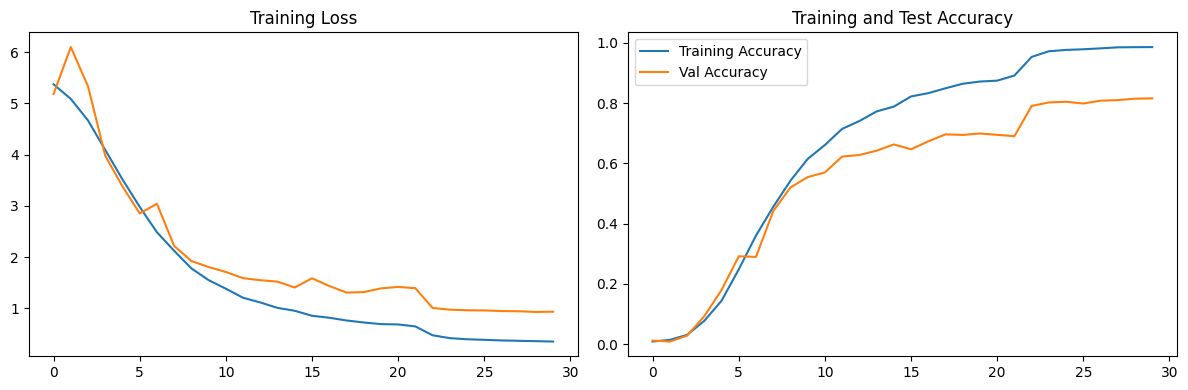

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

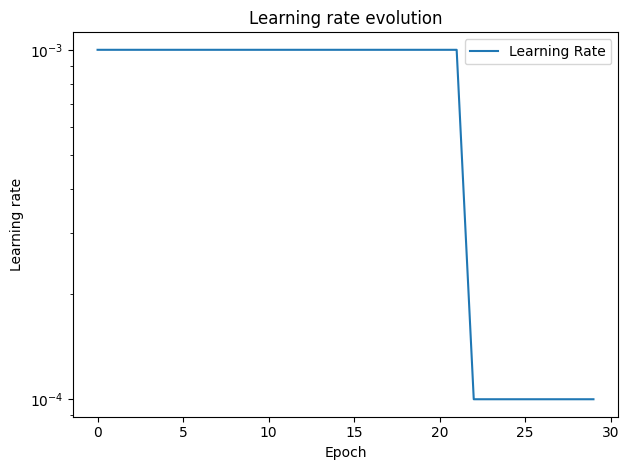

In [46]:
plt.plot(history['lr'])
plt.title("Learning rate evolution")
plt.legend(["Learning Rate"])

plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [48]:
import torch.nn.functional as F

# Set the model to evaluation mode
new_model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = new_model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

Final accuracy on the test dataset
0.8189460071128354


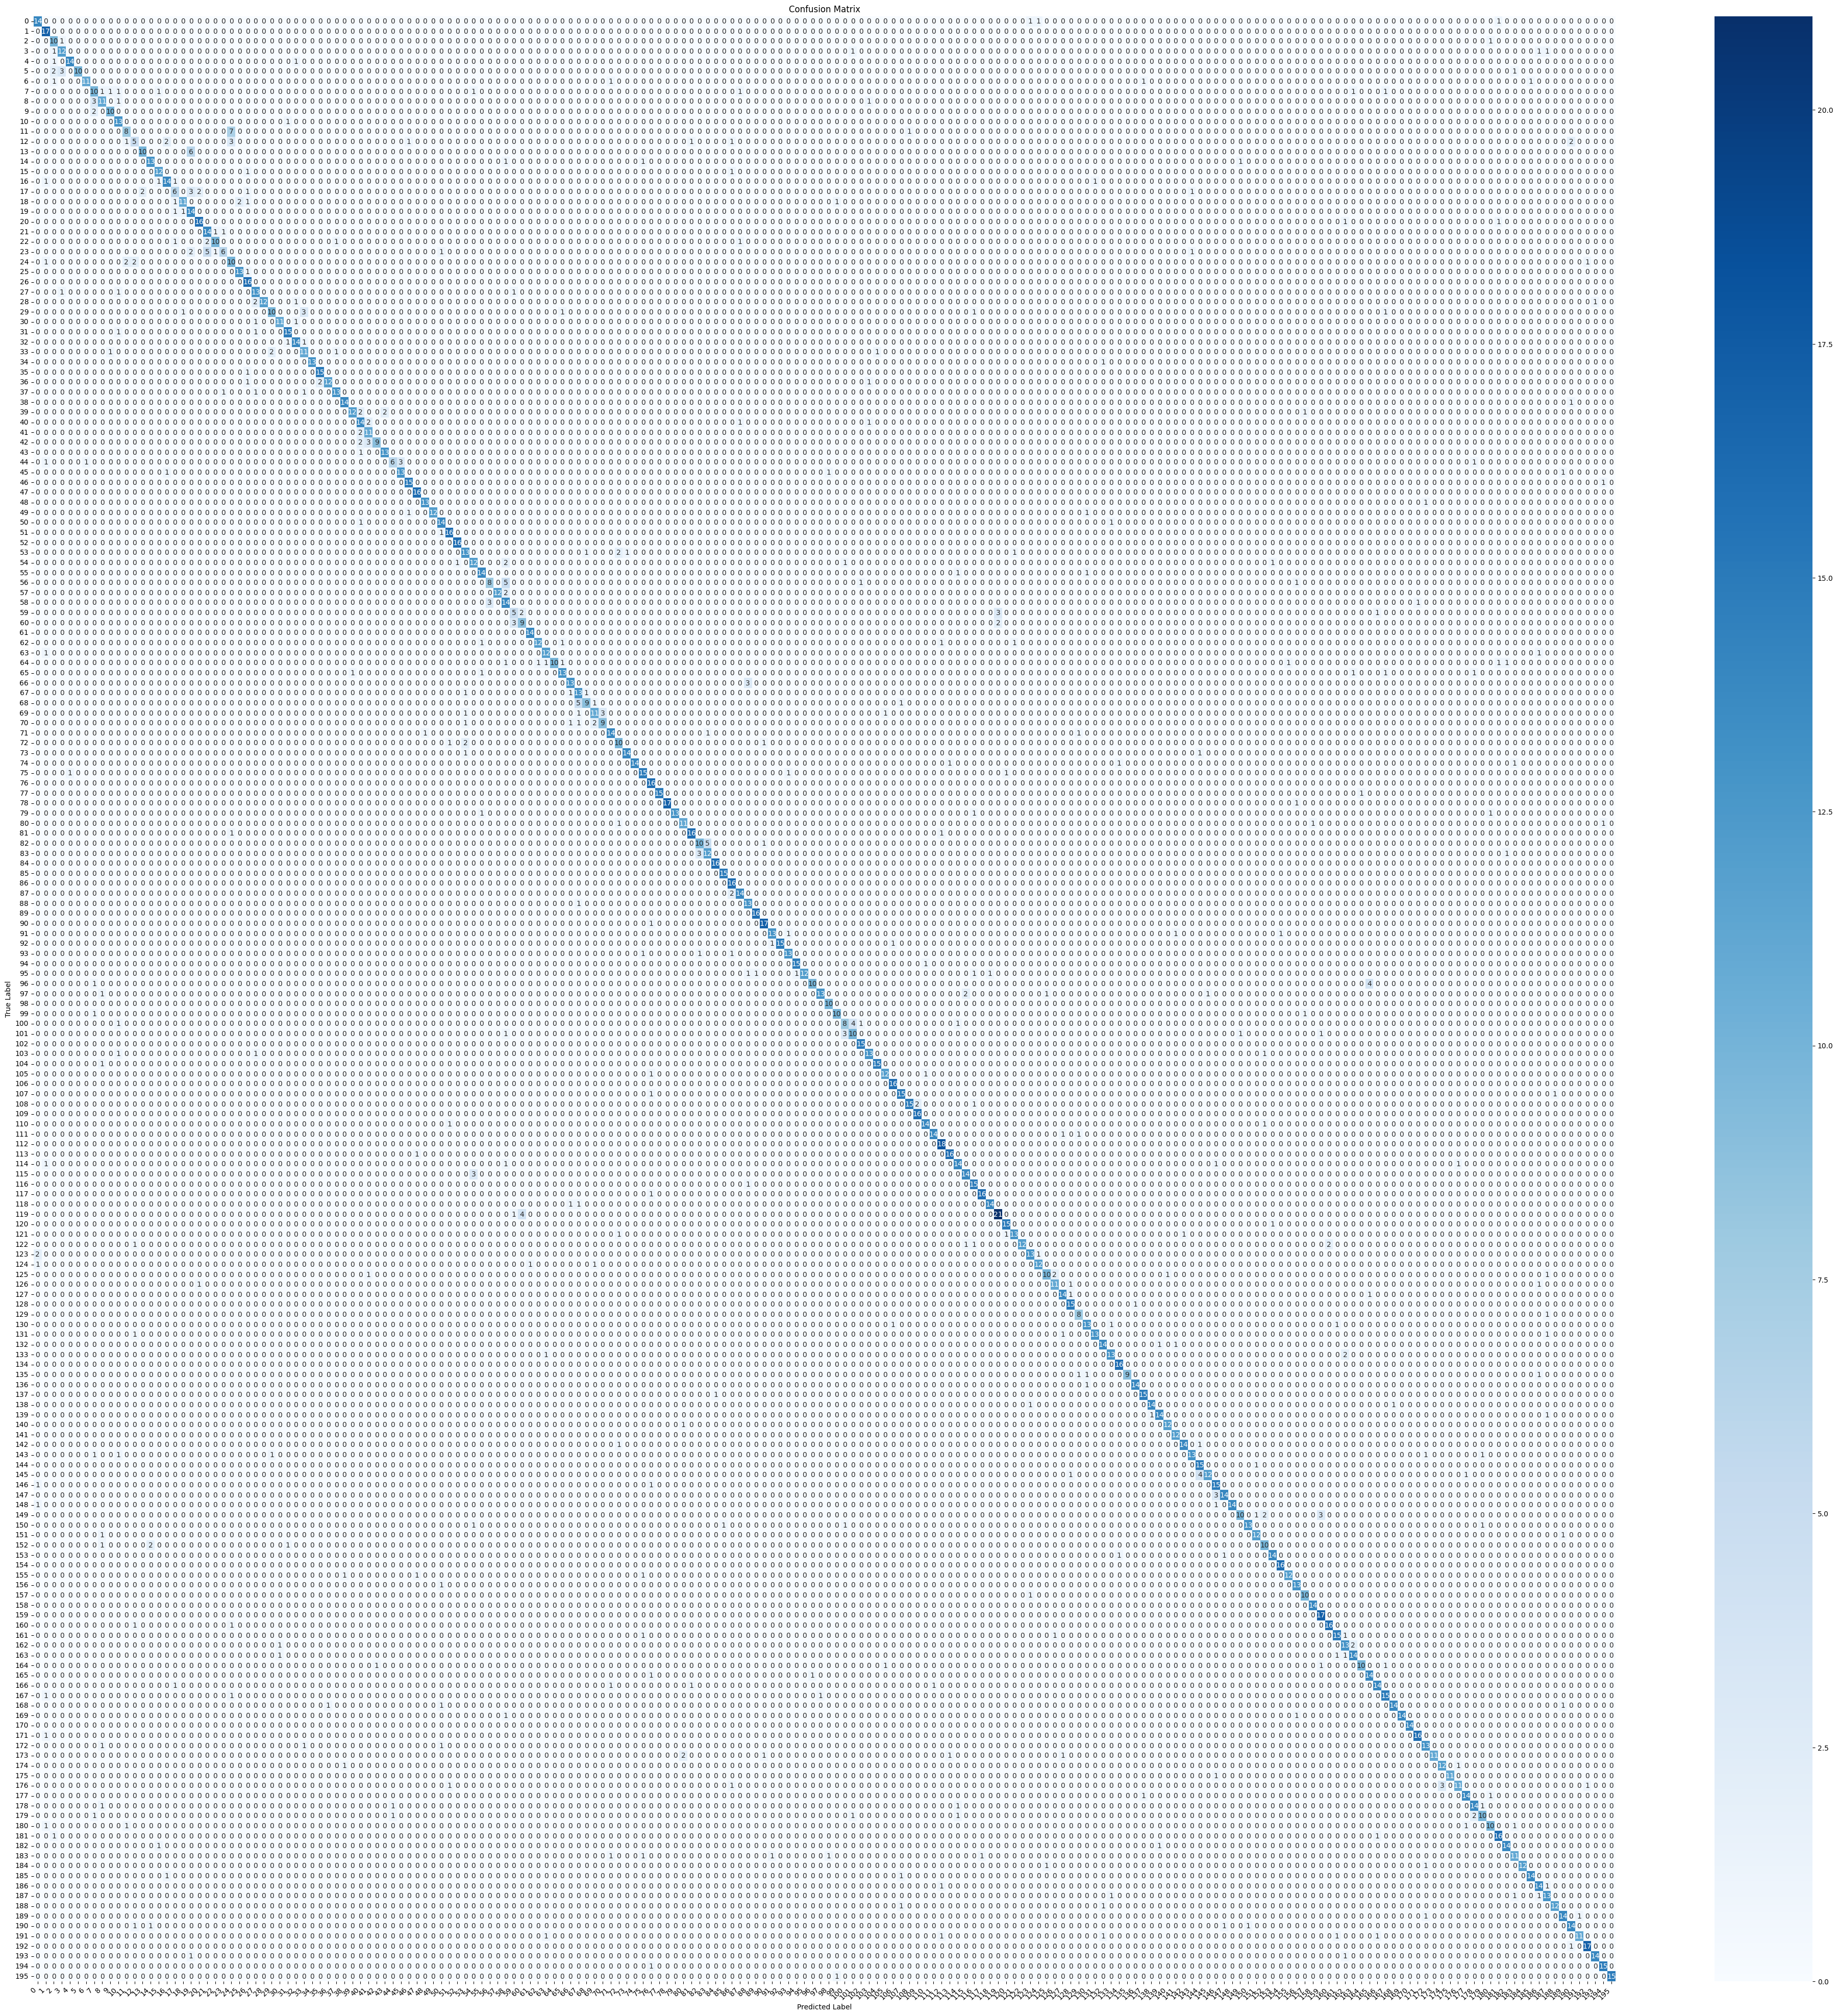

In [49]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [50]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.68      1.00      0.81        17
           2       0.62      0.83      0.71        12
           3       0.71      0.75      0.73        16
           4       0.93      0.88      0.90        16
           5       1.00      0.62      0.77        16
           6       0.92      0.73      0.81        15
           7       0.53      0.56      0.54        18
           8       0.61      0.69      0.65        16
           9       0.83      0.83      0.83        12
          10       0.65      0.93      0.76        14
          11       0.67      0.50      0.57        16
          12       0.45      0.31      0.37        16
          13       0.83      0.62      0.71        16
          14       0.81      0.81      0.81        16
          15       0.80      0.86      0.83        14
          16       0.78      0.78      0.78        18
          17       0.55    